In [69]:
import matplotlib.pyplot as plt
import numpy as np
from math import floor, ceil
from scipy.ndimage import rotate
from prep_image import prep_im_and_gt

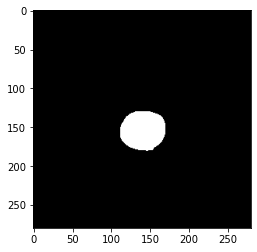

In [105]:
im, gt = prep_im_and_gt("PAT_289_1399_481", "test_images/", "test_image_groundtruths/", scalar=.25)
plt.imshow(gt, cmap="gray")

In [107]:
def cut_edges(image):
    col_sums = np.sum(image, axis=0)
    row_sums = np.sum(image, axis=1)

    active_cols = []
    for index, col_sum in enumerate(col_sums):
        if col_sum != 0:
            active_cols.append(index)

    active_rows = []
    for index, row_sum in enumerate(row_sums):
        if row_sum != 0:
            active_rows.append(index)

    col_min = active_cols[0]
    col_max = active_cols[-1]
    row_min = active_rows[0]
    row_max = active_rows[-1]

    cut_image = image[row_min:row_max, col_min:col_max]

    return cut_image

In [108]:
def midpoint(image):
    row_mid = image.shape[0] / 2
    col_mid = image.shape[1] / 2
    return row_mid, col_mid

(50, 57)
(25.0, 28.5)


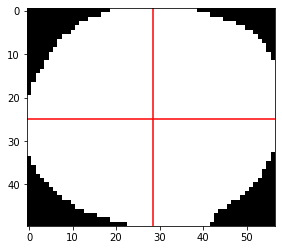

In [109]:
cut_gt = cut_edges(gt)

mp = midpoint(cut_gt)
print(cut_gt.shape)
print(mp)

x = mp[1]
y = mp[0]

plt.imshow(cut_gt, cmap="gray")
plt.axvline(x = x, color = "r")
plt.axhline(y = y, color = "r")

In [110]:
def asymmetry(image):
    '''Calculate asymmetry score between 0 and 1 from vertical and horizontal axis
    on a binary image, 0 being complete symmetry, 1 being complete asymmetry 
    (no pixels overlap when folding image on x- and y-axis)

    Args:
        image (numpy.ndarray): input image
    
    Returns:
        asymmetry_score (float): Float between 0 and 1 indicating level of asymmetry.    
    '''

    row_mid, col_mid = midpoint(image)

    # Split image into halves hortizontally and vertically
    upper_half = image[:ceil(row_mid), :]
    lower_half = image[floor(row_mid):, :]
    left_half = image[:, :ceil(col_mid)]
    right_half = image[:, floor(col_mid):]

    # Flip one half for each axis
    flipped_lower = np.flip(lower_half, axis=0)
    flipped_right = np.flip(right_half, axis=1)

    # Use logical xor to find pixels where only one half is present
    hori_xor_area = np.logical_xor(upper_half, flipped_lower)
    vert_xor_area = np.logical_xor(left_half, flipped_right)

    # Compute sums of total pixels and pixels in asymmetry areas
    total_pxls = np.sum(image)
    hori_asymmetry_pxls = np.sum(hori_xor_area)
    vert_asymmetry_pxls = np.sum(vert_xor_area)

    # Calculate asymmetry score
    asymmetry_score = (hori_asymmetry_pxls + vert_asymmetry_pxls) / (total_pxls * 2)

    return round(asymmetry_score, 4)

asymmetry_score = asymmetry(cut_gt)
print(asymmetry_score)

0.0319


In [111]:
def rotation_asymmetry(image, n: int):
    '''Rotate image n times and calculate asymmetry score for each iteration.
    Rotates n times between 0 and 90 degrees, as 90 degree rotations do not change the
    asymmetry score, i.e., a 30 degree rotation is the same as a 120 degree rotation.

    Args:
        image (numpy.ndarray): input image  
        n (int): amount of rotations

    Returns:
        asymmetry_scores (dict): dict of asymmetry scores calculated from each rotation.    
    '''

    asymmetry_scores = {}
    images = []

    for i in range(n):

        degrees = 90 * i / n

        rotated_image = rotate(image, degrees)
        cut_image = cut_edges(rotated_image)

        images.append(cut_image)
        asymmetry_scores[degrees] = asymmetry(cut_image)

    return asymmetry_scores, images

asymmetry_scores, images = rotation_asymmetry(gt, 30)

print(asymmetry_scores)

# Plotting
#fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(10, 10))
#for row in range(3):
#    for col in range(4):
#        image = images[4*row + col]
#        axes[row, col].imshow(image, cmap="gray")
#        mp = midpoint(image)
#        axes[row, col].axvline(x = mp[1], color = "r")
#        axes[row, col].axhline(y = mp[0], color = "r")
#        axes[row, col].set_title(f"rotation: {7.5*(4*row + col)}")
#fig.tight_layout

{0.0: 0.0319, 3.0: 0.0404, 6.0: 0.0495, 9.0: 0.0571, 12.0: 0.0611, 15.0: 0.0652, 18.0: 0.0695, 21.0: 0.0791, 24.0: 0.0847, 27.0: 0.0886, 30.0: 0.0904, 33.0: 0.0928, 36.0: 0.0961, 39.0: 0.099, 42.0: 0.0961, 45.0: 0.0926, 48.0: 0.0917, 51.0: 0.0854, 54.0: 0.0808, 57.0: 0.0756, 60.0: 0.0664, 63.0: 0.0576, 66.0: 0.0526, 69.0: 0.0484, 72.0: 0.0449, 75.0: 0.04, 78.0: 0.0356, 81.0: 0.0345, 84.0: 0.0322, 87.0: 0.0302}


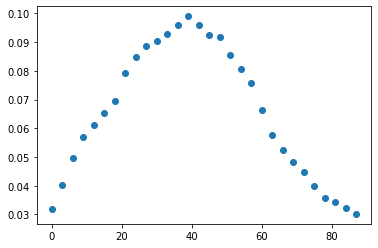

In [112]:
plt.scatter(asymmetry_scores.keys(), asymmetry_scores.values())

In [116]:
best_asymmetry = min(asymmetry_scores.items(), key=lambda x: x[1]) 
worst_asymmetry = max(asymmetry_scores.items(), key=lambda x: x[1]) 
avr_asymmetry = round(sum(asymmetry_scores.values()) / len(asymmetry_scores), 4)

print(f"Best asymmetry (angle, score): {best_asymmetry}")
print(f"Worst asymmetry (angle, score): {worst_asymmetry}")
print(f"Average asymmetry: {avr_asymmetry}")

Best asymmetry (angle, score): (87.0, 0.0302)
Worst asymmetry (angle, score): (39.0, 0.099)
Average asymmetry: 0.0657
